In [1]:
import torch

from reggae.utilities import save, load

from reggae.gp.variational.models import NonLinearLFM, ExponentialLFM
from reggae.gp.variational.trainer import TranscriptionalTrainer
from reggae.gp.variational.options import VariationalOptions
from reggae.data_loaders import HafnerData
from reggae.plot.variational_plotters import Plotter
from matplotlib import pyplot as plt

import numpy as np

f64 = np.float64

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]) tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])


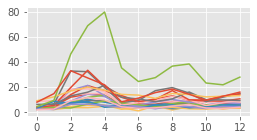

In [2]:
dataset = HafnerData(replicate=0, data_dir='../data/', extra_targets=False)
num_replicates = 1
num_genes = len(dataset.gene_names)
num_tfs = 1
num_times = dataset[0][0].shape[0]

print(dataset[0][0], dataset.t)
t_inducing = torch.linspace(0, 12, num_times, dtype=torch.float64).reshape((-1, 1))
t_observed = torch.linspace(0, 12, num_times)
t_predict = torch.linspace(-2, 14, 80, dtype=torch.float64)

m_observed = torch.stack([
    dataset[i][1] for i in range(num_genes*num_replicates)
]).view(num_replicates, num_genes, num_times)

plt.figure(figsize=(4, 2))
for i in range(22):
    plt.plot(dataset[i][1])

In [3]:
print(t_inducing, t_observed)

tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.]], dtype=torch.float64) tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])


In [4]:
options = VariationalOptions(
    learn_inducing=False,
    num_samples=50,
    kernel_scale=False,
    initial_conditions=True
)

model = NonLinearLFM(num_genes, num_tfs, t_inducing, dataset, options)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
trainer = TranscriptionalTrainer(model, optimizer, dataset)
plotter = Plotter(model, np.array(dataset.gene_names))

C:\Users\Jacob\Documents\proj\reggae\reggae\gp\variational\models\model.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = Parameter(torch.tensor(t_inducing), requires_grad=options.learn_inducing)
C:\Users\Jacob\Documents\proj\reggae\reggae\gp\variational\models\model.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


### Outputs prior to training:

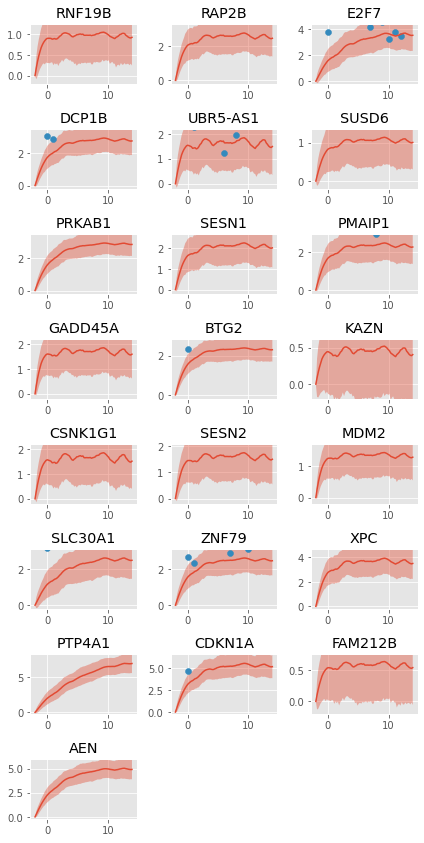

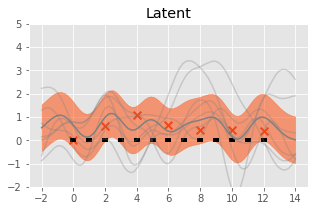

In [5]:
rtol = 1e-2
atol = rtol/10

model_kwargs = {
    'rtol': rtol, 'atol': atol
}

plotter.plot_outputs(t_predict, t_scatter=t_observed,y_scatter=m_observed, model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-2, 5), plot_barenco=True, plot_inducing=False)

Epoch 1/200 - Loss: 14413.85 (14413.85 0.00) λ: 1.423 b: 0.60 d 0.91 s: 0.52
Epoch 6/200 - Loss: 6456.50 (6432.04 24.47) λ: 1.165 b: 1.10 d 0.42 s: 1.03
Epoch 11/200 - Loss: 3695.02 (3675.99 19.03) λ: 0.939 b: 1.34 d 0.39 s: 1.28
Epoch 16/200 - Loss: 2061.95 (2030.39 31.56) λ: 0.777 b: 1.37 d 0.62 s: 1.30
Epoch 21/200 - Loss: 1531.66 (1493.08 38.57) λ: 0.615 b: 1.44 d 0.73 s: 1.35
Epoch 26/200 - Loss: 1250.90 (1202.60 48.31) λ: 0.490 b: 1.52 d 0.77 s: 1.37
Epoch 31/200 - Loss: 1082.85 (1028.50 54.35) λ: 0.418 b: 1.60 d 0.79 s: 1.31
Epoch 36/200 - Loss: 935.96 (875.39 60.57) λ: 0.405 b: 1.66 d 0.80 s: 1.19
Epoch 41/200 - Loss: 909.79 (844.46 65.33) λ: 0.388 b: 1.71 d 0.80 s: 1.07
Epoch 46/200 - Loss: 831.51 (768.86 62.64) λ: 0.377 b: 1.76 d 0.78 s: 1.00
Epoch 51/200 - Loss: 803.12 (742.79 60.33) λ: 0.426 b: 1.81 d 0.73 s: 0.98
Epoch 56/200 - Loss: 757.88 (701.08 56.80) λ: 0.460 b: 1.85 d 0.71 s: 0.90
Epoch 61/200 - Loss: 750.82 (694.15 56.67) λ: 0.519 b: 1.88 d 0.68 s: 0.83
Epoch 66/200

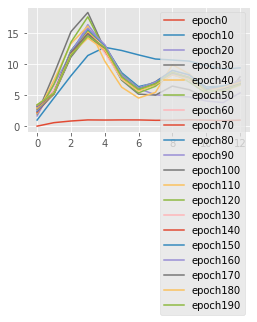

In [6]:
tol = 5e-3
# trainer = Trainer(optimizer)
output = trainer.train(200, rtol=tol, atol=tol/10, report_interval=5, plot_interval=10)

### Outputs after training

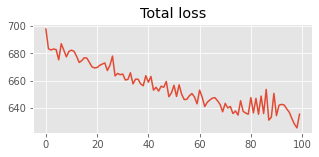

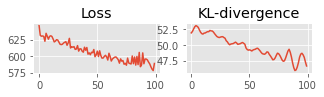

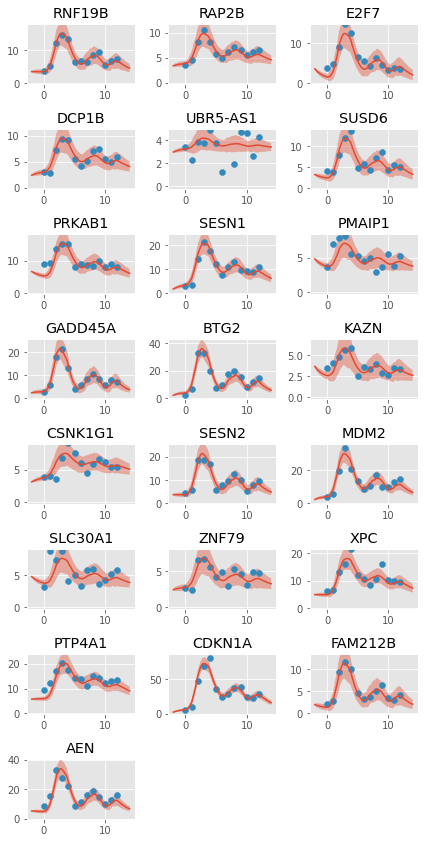

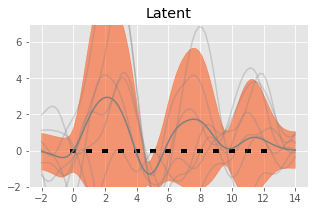

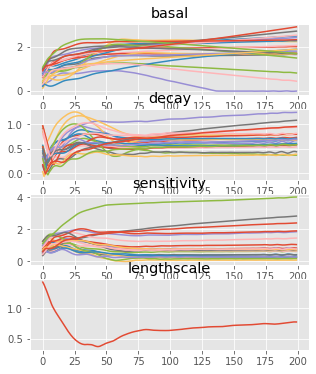

In [7]:
plotter.plot_losses(trainer, last_x=100)
plotter.plot_outputs(t_predict, replicate=0, t_scatter=t_observed,y_scatter=m_observed, model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-2, 7), plot_inducing=False)
plotter.plot_convergence(trainer)

In [ ]:
save(model, 'nonlinear')

In [ ]:
do_load = False
if do_load:
    model = load('nonlinear', NonLinearLFM, num_genes, num_tfs,
                 t_inducing, dataset, extra_points=2, fixed_variance=dataset.variance)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    trainer = TranscriptionalTrainer(model, optimizer, dataset)
